In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 21.7 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [6]:
import warnings
warnings.filterwarnings("ignore")

# 1. Loading the data

In [7]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
dataset = torchvision.datasets.ImageFolder('/content/gdrive/MyDrive/WikiArt')
dataset

Dataset ImageFolder
    Number of datapoints: 42500
    Root location: /content/gdrive/MyDrive/WikiArt

In [9]:
# Split the dataset into train set and validation + test set
# Stratified Sampling for train set and val_test set
train_index, val_test_index= train_test_split(
np.arange(len(dataset.targets)),
test_size=0.2, random_state=91,
shuffle=True,
stratify=dataset.targets)

In [10]:
val_test_index

array([  997, 19222, 41901, ...,  7366, 15197, 16025])

In [11]:
# Split the val set and test set from val_test set:
test_index, val_index= train_test_split(
val_test_index,
test_size=0.5, random_state=91,
shuffle=True,
stratify=[dataset.targets[i] for i in val_test_index])

# 2. Preprocess the data

Huggingface models require 2 things: pixel_values and labels.

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as image transformations.

In addition, one typically performs what is called data augmentation during training (like random cropping and flipping) to make the model more robust and achieve higher accuracy. Data augmentation is also a great technique to increase the size of the training data. The following augmentation techniques are considered:

- RandomResizedCrop: This technique randomly crops and resizes the input image to a specified size. It helps in introducing variations in the scale and aspect ratio of the input images.
- RandomHorizontalFlip: This technique randomly flips the input image horizontally. The given image was randomly flipped horizontally at a preset probability of 50%
- RandomGrayscale: Convert image to grayscale. Because there is a considerable proportion of images are grayscale, our models need to be invariant to color variations, converting images to grayscale can help achieve this. By removing color information, the model focuses solely on the intensity values, making it less sensitive to changes in color distribution or lighting conditions.

In [12]:
from transformers import BeitImageProcessor
from torchvision.transforms.v2 import Compose, Normalize, Resize, ToTensor, RandomHorizontalFlip, RandomRotation, RandomResizedCrop, CenterCrop

In [13]:
model_name = "microsoft/beit-base-patch16-224-pt22k-ft22k"
image_processor = BeitImageProcessor.from_pretrained(model_name)
image_processor

preprocessor_config.json:   0%|          | 0.00/276 [00:00<?, ?B/s]

BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [14]:
image_mean, image_std = image_processor.image_mean, image_processor.image_std
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

In [15]:
normalize = Normalize(mean=image_mean, std=image_std)
train_transforms = Compose([
    RandomResizedCrop(crop_size),
    RandomHorizontalFlip(),
    RandomRotation(10),
    ToTensor(),
    normalize])

val_test_transforms = Compose([
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize])

In [16]:
class TransformDataset(torch.utils.data.Dataset):
  def __init__(self, base_dataset, transformations):
    super(TransformDataset, self).__init__()
    self.base = base_dataset
    self.transformations = transformations

  def __len__(self):
    return len(self.base)

  def __getitem__(self, idx):
    x, y = self.base[idx]
    return self.transformations(x), y

In [17]:
# Subset dataset for train, test and val
train_subset = torch.utils.data.Subset(dataset, train_index)
test_subset = torch.utils.data.Subset(dataset, test_index)
val_subset = torch.utils.data.Subset(dataset, val_index)

In [18]:
# Apply data augmentation and transformation to the subsets:
train_dataset = TransformDataset(train_subset, train_transforms)
test_dataset = TransformDataset(test_subset, val_test_transforms)
val_dataset = TransformDataset(val_subset, val_test_transforms)

In [19]:
print('number of train images: {}'.format(len(train_dataset)))
print('number of test images: {}'.format(len(test_dataset)))
print('number of val images: {}'.format(len(val_dataset)))

number of train images: 34000
number of test images: 4250
number of val images: 4250


In [20]:
label2id = {}
id2label = {}

for i, class_name in enumerate(dataset.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [21]:
# Create a custom collator:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor

    def __call__(self, batch):
        pixel_values =  torch.stack([x[0] for x in batch])
        labels = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return {"pixel_values": pixel_values, "labels": labels}
collator = ImageClassificationCollator(image_processor)

In [22]:
# # create corresponding PyTorch DataLoaders for Pytorch Lightning:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, num_workers=8, shuffle=True, collate_fn=collator, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, num_workers=16, shuffle=False, collate_fn=collator, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, num_workers=16, shuffle=False, collate_fn=collator, pin_memory=True)

# 3. Define and train the model

In [23]:
import pytorch_lightning as pl
from transformers import BeitForImageClassification, AdamW
import torch.nn as nn

In [24]:
class ViTLightningModule(pl.LightningModule):
    def __init__(self):
        super(ViTLightningModule, self).__init__()
        self.vit = BeitForImageClassification.from_pretrained(model_name,
                                                              num_labels=len(id2label),
                                                              id2label=id2label,
                                                              label2id=label2id,
                                                              ignore_mismatched_sizes=True,
                                                              hidden_dropout_prob = 0.1,
                                                              attention_probs_dropout_prob = 0.1)

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

    def common_step(self, batch, batch_idx):
        pixel_values = batch['pixel_values']
        labels = batch['labels']
        logits = self(pixel_values)

        criterion = nn.CrossEntropyLoss()
        loss = criterion(logits, labels)
        predictions = logits.argmax(-1)
        correct = (predictions == labels).sum().item()
        accuracy = correct/pixel_values.shape[0]
        return loss, accuracy

    def training_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_acc", accuracy, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        self.log("val_acc", accuracy, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, accuracy = self.common_step(batch, batch_idx)
        self.log("test_loss", loss, on_epoch=True, prog_bar=True)
        self.log("test_acc", accuracy, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # We could make the optimizer more fancy by adding a scheduler and specifying which parameters do
        # not require weight_decay but just using AdamW out-of-the-box works fine
        return AdamW(self.parameters(), lr=2e-5)

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return val_loader

    def test_dataloader(self):
        return test_loader

In [25]:
pl.seed_everything(91)
model = ViTLightningModule.load_from_checkpoint('/content/gdrive/MyDrive/checkpoints/BEiT16/lightning_logs/version_0/checkpoints/model-epoch=14-val_acc=0.8038-val_f1score=0.7217.ckpt')

INFO:lightning_fabric.utilities.seed:Seed set to 91


config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/414M [00:00<?, ?B/s]

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k-ft22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 768]) in the checkpoint and torch.Size([13, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([13]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
trainer = pl.Trainer(accelerator='gpu')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [27]:
test_preds = []
test_targets = []
with torch.no_grad():
  for data in test_loader:
    pixel_values = data['pixel_values'].to(model.device)
    outputs = model(pixel_values)
    probabilities = torch.nn.functional.softmax(outputs, dim=-1)
    logits = torch.log(probabilities)
    predicted_class_idx = logits.argmax(-1).tolist()
    test_preds.extend(predicted_class_idx)
    test_targets.extend(data['labels'].tolist())

In [29]:
len(test_preds)

4250

In [30]:
len(test_targets)

4250

In [31]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [32]:
id2label.values()

dict_values(['Academic_Art', 'Art_Nouveau', 'Baroque', 'Expressionism', 'Japanese_Art', 'Neoclassicism', 'Primitivism', 'Realism', 'Renaissance', 'Rococo', 'Romanticism', 'Symbolism', 'Western_Medieval'])

In [33]:
cm = confusion_matrix(test_targets, test_preds)

In [34]:
cm_df = pd.DataFrame(cm, index=id2label.values(), columns=id2label.values())

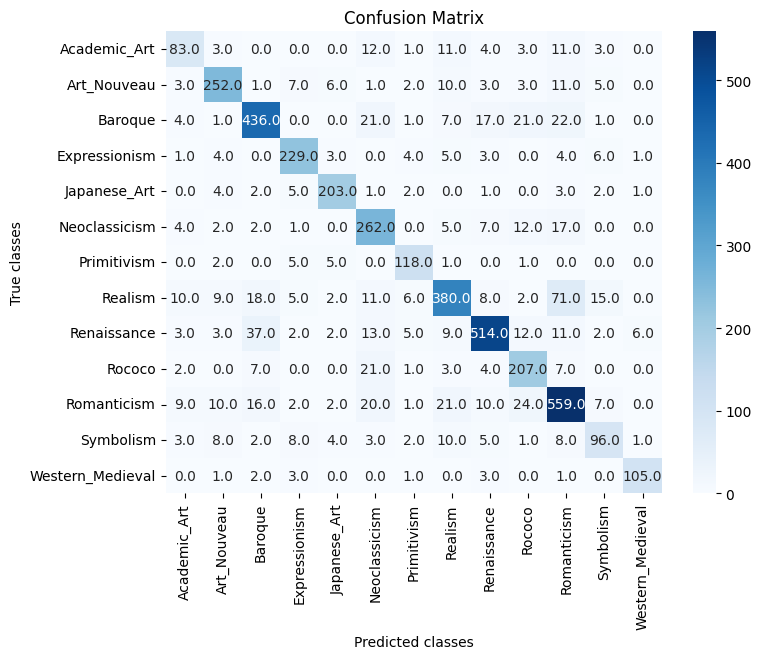

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()

In [36]:
cm = confusion_matrix(test_targets, test_preds, normalize = 'true')

In [37]:
cm_df = pd.DataFrame(cm, index=id2label.values(), columns=id2label.values())

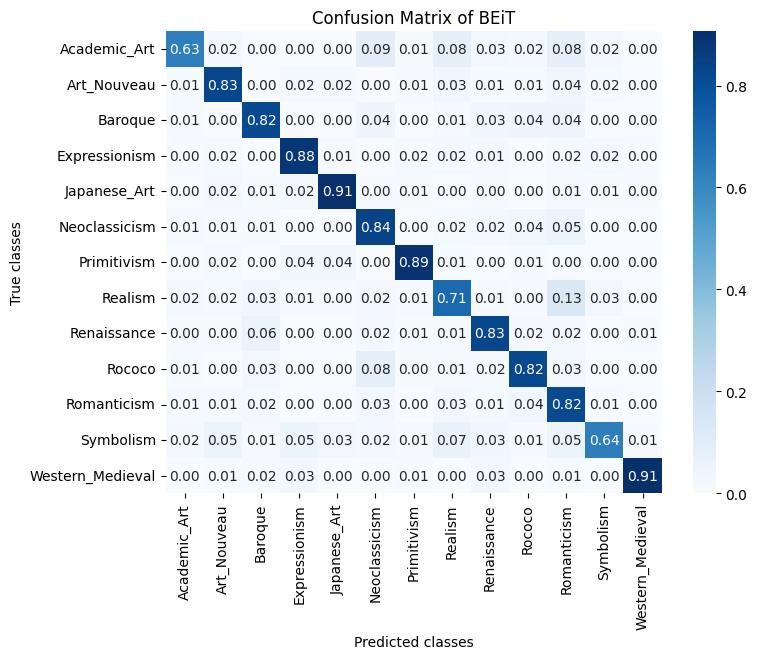

In [39]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='.2f')
plt.title('Confusion Matrix of BEiT')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')
plt.show()

In [40]:
f1_score(test_targets, test_preds, average='macro',zero_division='warn')

0.8062220968544291

In [41]:
f1_score(test_targets, test_preds, average='micro',zero_division='warn')

0.8103529411764706

In [42]:
accuracy_score(test_targets, test_preds, normalize=True, sample_weight=None)

0.8103529411764706

In [43]:
val_preds = []
val_targets = []
with torch.no_grad():
  for data in val_loader:
    pixel_values = data['pixel_values'].to(model.device)
    outputs = model(pixel_values)
    probabilities = torch.nn.functional.softmax(outputs, dim=-1)
    logits = torch.log(probabilities)
    predicted_class_idx = logits.argmax(-1).tolist()
    val_preds.extend(predicted_class_idx)
    val_targets.extend(data['labels'].tolist())

In [44]:
f1_score(val_targets, val_preds, average='macro',zero_division='warn')

0.7952581080317128

In [45]:
f1_score(val_targets, val_preds, average='micro',zero_division='warn')

0.8035294117647059

In [46]:
accuracy_score(val_targets, val_preds, normalize=True, sample_weight=None)

0.8035294117647059